In [374]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random
import seaborn as sns
from kramersmoyal import km, kernels
from tqdm import tqdm
%matplotlib inline

In [320]:
sns.set()

In [321]:
H1_data = pd.read_csv("GJ_1H_BID_NW.csv")

In [322]:
H1_data.head()

,Local time,Open,High,Low,Close,Volume
0,08.05.2019 00:00:00.000 GMT+0200,144.121,144.167,144.073,144.106,1492.8400
1,08.05.2019 01:00:00.000 GMT+0200,144.107,144.134,144.030,144.084,1834.7600
2,08.05.2019 02:00:00.000 GMT+0200,144.080,144.082,143.885,143.979,6151.7700
3,08.05.2019 03:00:00.000 GMT+0200,143.981,144.055,143.918,143.937,4850.4399
4,08.05.2019 04:00:00.000 GMT+0200,143.941,143.942,143.785,143.862,7991.7402


In [323]:
close_data = H1_data['Close'].to_numpy()

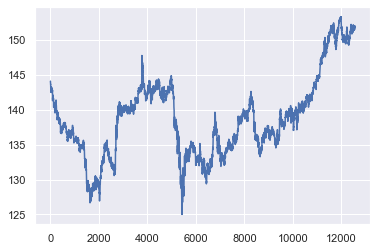

In [324]:
plt.plot(close_data)

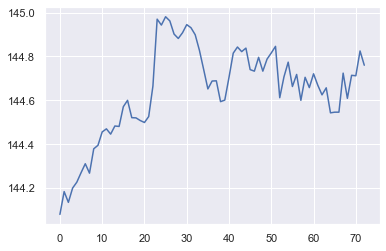

In [325]:
plt.plot(close_data[11027:11100])

In [326]:
#length scales, scale1 < scale 0
delta_t1 = 1;
delta_t0 = 2;
#bins per scale
numBins_r1 = 150; 
numBins_r0 = 150;

In [327]:
#define and standardize returns series

r1 = [np.log(H1_data["Close"][i + delta_t1] / H1_data["Close"][i]) for i in range(len(H1_data["Close"])-delta_t1)]
r0 = [np.log(H1_data["Close"][i + delta_t0] / H1_data["Close"][i]) for i in range(len(H1_data["Close"])-delta_t0)]
dif = len(r1) - len(r0)
r1 = r1[:-dif]

sig_r_orig = np.std(r1)
mu_r_orig = np.mean(r1)

print(np.std(r1))

r1 = r1 / (10*np.std(r1))
r0 = r0 / (10*np.std(r0))

print(np.std(r1))

0.0013318701610205198
0.1


In [328]:
#bin the return series into the number of bins

#Bins for r1
lowLimit_r1 = min(r1);
upLimit_r1 = max(r1)+ 1;
binLimits_r1 = np.linspace(lowLimit_r1, upLimit_r1, numBins_r1 +1);
whichBin_r1= np.digitize(r1, binLimits_r1);

#Bins for r0
lowLimit_r0 = min(r0);
upLimit_r0 = max(r0)+ 1;
binLimits_r0 = np.linspace(lowLimit_r0, upLimit_r0, numBins_r0 +1);
whichBin_r0= np.digitize(r0, binLimits_r0)

In [329]:
#compute the mean of each bin

binMean_r0 = []

for i in range(1,numBins_r0+1):
    binMembers_r0 = [r0[idx] for idx, element in enumerate(whichBin_r0) if element == i]
    binMean_r0.append(np.mean(binMembers_r0))

    
binMean_r1 = []

for i in range(1,numBins_r1+1):
    binMembers_r1 = [r1[idx] for idx, element in enumerate(whichBin_r1) if element == i]
    binMean_r1.append(np.mean(binMembers_r1))

C:\Users\Steven\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Steven\Anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [330]:
#binned data

r1_Binned = [binMean_r1[idx - 1] for idx in whichBin_r1]
r0_Binned = [binMean_r0[idx - 1] for idx in whichBin_r0]

binned_dataframe = pd.DataFrame(
    {'r1_Binned': r1_Binned,
     'r0_Binned': r0_Binned
    })

In [332]:
#define function to compute probability of items in each returns series
def tabulate(vector):
    vals, counts = np.unique(vector, return_counts=True)
    percentage = [count/len(vector) * 100 for count in counts]
    return np.array(vals), np.array(counts), np.array(percentage)

In [333]:
#compute p(r1|r0)
vals_r0, counts_r0, percentage_r0 = tabulate(r0_Binned)
Prob_r0 = percentage_r0/100
MassPDF_r1_r0_df = pd.crosstab(index=binned_dataframe['r1_Binned'], columns=binned_dataframe['r0_Binned'])
MassPDF_r1_r0 = MassPDF_r1_r0_df.to_numpy()
JointPDF_r1_r0 = MassPDF_r1_r0/(len(r0_Binned));
CondPDF_r1_r0 = np.linalg.solve(np.diag(Prob_r0).conj().T, JointPDF_r1_r0.conj().T).conj().T

In [334]:
#unique occurences of each binned element
Mx = np.unique(r0_Binned);
My = np.unique(r1_Binned);
nrows, ncol = JointPDF_r1_r0.shape

# KM Coefficients Using Histogramming Method

In [335]:
#compute matrix for KM1
Dx = np.zeros((nrows,ncol));
for row in range(nrows):
    for col in range(ncol):
        Dx[row][col] = (My[row] - Mx[col]) * CondPDF_r1_r0[row][col]
        
KM1 =- (r1/r1-r0)*np.sum(Dx, axis = 0);

D1 = -0.3186436319877123r 0.0010944612701434308


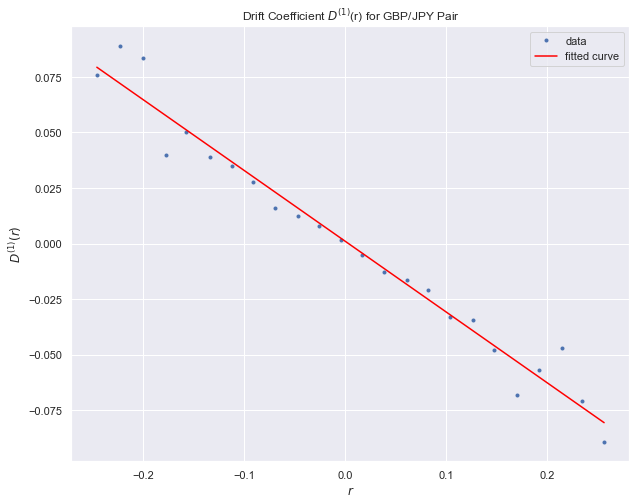

In [336]:
#plot KM1 and fit linear polynomial
plt.figure(figsize = (10, 8))
plt.title(r"Drift Coefficient $D^{(1)}$(r) for GBP/JPY Pair")

idx1 = 22
idx2 = -25

coeffKM1 = np.polyfit(Mx[idx1:idx2], KM1[idx1:idx2], 1)
fitKM1 = np.poly1d(coeffKM1)
plt.plot(Mx[idx1:idx2], KM1[idx1:idx2], 'b.', label = 'data')
plt.plot(Mx[idx1:idx2],fitKM1(Mx[idx1:idx2]), color = 'red', label= "fitted curve")
plt.legend()

plt.xlabel(r'$r$')
plt.ylabel(r'$D^{(1)}(r)$')
plt.savefig('./plots/KM1.png')
print(f"D1 = {coeffKM1[0]}r {coeffKM1[1] }")

In [337]:
#compute matrix for KM2
for row in range(nrows):
    for col in range(ncol):
        Dx[row][col] = (My[row] - Mx[col])**2 * CondPDF_r1_r0[row][col]
        
KM2 =- (1.0/2.0) * (r1/r1-r0)*np.sum(Dx, axis = 0);

D2 = 0.1906044846013698r^2 0.0010944612701434308r -0.3186436319877123
        2
0.1906 x - 0.002335 x + 0.00113


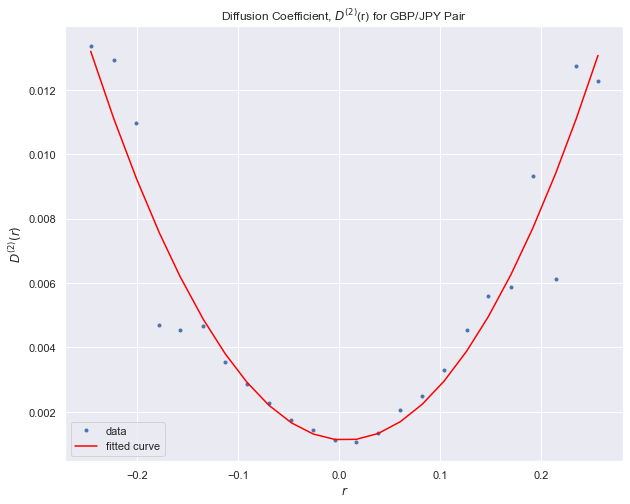

In [339]:
#plot KM2 and fit quadratic polynomial
plt.figure(figsize = (10, 8))
plt.title(r"Diffusion Coefficient, $D^{(2)}$(r) for GBP/JPY Pair")

idx1 = 22
idx2 = 46
fact = 1
coeffKM2 = np.polyfit(Mx[idx1:idx2], KM2[idx1:idx2]*fact, 2)
fitKM2 = np.poly1d(coeffKM2)
plt.plot(Mx[idx1:idx2], KM2[idx1:idx2]*fact, 'b.', label = 'data')
plt.plot(Mx[idx1:idx2],fitKM2(Mx[idx1:idx2]), color = 'red', label= "fitted curve")
plt.legend()

plt.xlabel(r'$r$')
plt.ylabel(r'$D^{(2)}(r)$')
plt.savefig('./plots/KM2.png')

print(f"D2 = {coeffKM2[0]}r^2 {coeffKM1[1]}r {coeffKM1[0]}")

In [401]:
for row in range(nrows):
    for col in range(ncol):
        Dx[row][col] = (My[row] - Mx[col])**4 * CondPDF_r1_r0[row][col]
        
KM4 =- (1.0/24.0) *(r0/r1 - r0)* np.sum(Dx, axis = 0)

In [ ]:
plt.figure(figsize = (10, 8))
plt.plot(Mx[3:], KM4[3:], 'b.')
coeffKM4 = np.polyfit(Mx[idx1:idx2], KM2[idx1:idx2]*fact, 2)
fitKM4 = np.poly1d(coeffKM2)
plt.xlim(-0.7, 0.7);
plt.ylim(-0.005, 0.015)
plt.title("Fourth Kramers-Moyal Coefficient")
plt.xlabel(r"$r$")
plt.ylabel(r"$D^{(4)}(r)$")
plt.savefig("./plots/KM4.png")

# KM Coefficients via kramersmoyal package

In [342]:
# Choose number of points of you target space
bins = np.array([150])

# Choose powers to calculate
powers = np.array([[1], [2]])

# Choose a desired bandwith
bw = 0.105

# The kmc holds the results, where edges holds the binning space
kmc, edges = km(r1, kernel = kernels.gaussian, bw = bw, bins = bins, powers = powers)

D1 = -0.35783280082202906r -0.001354148890859037


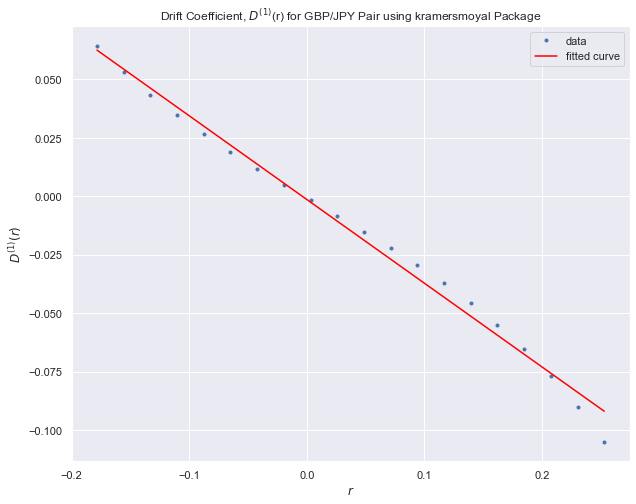

In [343]:
#compute and plot KM1 and fit linear polynomial
idx1 = 60
idx2 = -70

plt.figure(figsize = (10, 8))
plt.plot(edges[0][idx1:idx2], kmc[0,idx1:idx2], 'b.', label = r'data')

plt.title(r"Drift Coefficient, $D^{(1)}$(r) for GBP/JPY Pair using kramersmoyal Package")

k_coeffKM1 = np.polyfit(edges[0][idx1:idx2], kmc[0,idx1:idx2], 1)
k_fitKM1 = np.poly1d(k_coeffKM1)

plt.plot(edges[0][idx1:idx2],k_fitKM1(edges[0][idx1:idx2]), color = 'red', label= "fitted curve")

plt.xlabel(r'$r$')
plt.ylabel(r'$D^{(1)}(r)$')
print(f"D1 = {k_coeffKM1[0]}r {k_coeffKM1[1] }")
plt.legend()
plt.savefig('./plots/KM1_pack.png')

D2 = 0.16534254700063686r^2 -0.0016455755479834154 0.0052414675801375


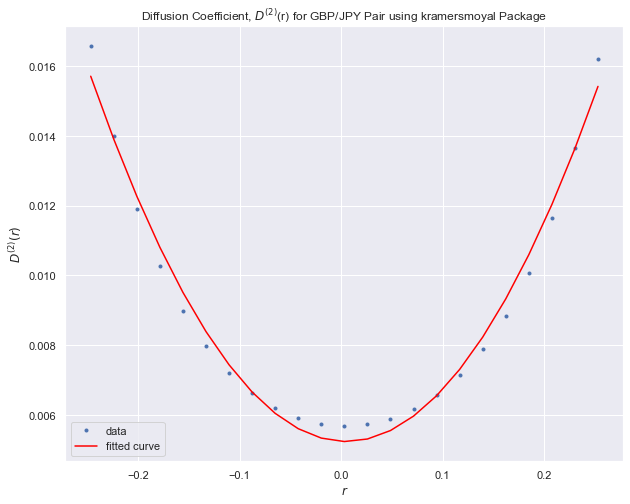

In [344]:
#compute and plot KM2 and fit quadratic polynomial

idx1 = 57
idx2 = -70

plt.figure(figsize = (10, 8))
plt.title(r"Diffusion Coefficient, $D^{(2)}$(r) for GBP/JPY Pair using kramersmoyal Package")
plt.plot(edges[0][idx1:idx2], kmc[1,idx1:idx2], 'b.', label = r'data')

k_coeffKM2 = np.polyfit(edges[0][idx1:idx2], kmc[1,idx1:idx2], 2)
k_fitKM2 = np.poly1d(k_coeffKM2)

plt.plot(edges[0][idx1:idx2],k_fitKM2(edges[0][idx1:idx2]), color = 'red', label= "fitted curve")

plt.xlabel(r'$r$')
plt.ylabel(r'$D^{(2)}(r)$')
print(f"D2 = {k_coeffKM2[0]}r^2 {k_coeffKM2[1] } {k_coeffKM2[2] }")
plt.legend()
plt.savefig('./plots/KM2_pack_p2.png')

In [348]:
#define KM functions and a retuns update equation

def D1(r):
    return fitKM1[0]*r + fitKM1[1]

def D2(r):
    return fitKM2[0]* r**2 + fitKM2[1]*r + fitKM2[2]

mu, sigma = 0, 2.0

def return_new(r_old):
    return D1(r_old) + np.sqrt(D2(r_old))*random.gauss(mu, sigma) + r_old

In [355]:
#want to use the arrays
#close_data

#r1

#sideways = 4170
#voltile  = 5082
#trend    = 11027

In [377]:
%matplotlib qt

In [400]:
#run stochastic simluation 

errs = []
plot = False
for i in tqdm(range(10000)):

    x_preds = []

    start = 11027
    shift = 6
    
    for j in range (100):
        x_init = close_data[start]
        x_pred = [x_init]

        r1_init = r1[start]
        r_pred = [r1_init]

        for i in range(shift):
            x_pred.append( x_pred[-1] * np.exp( 10 * sig_r_orig * ( return_new(r_pred[-1]) + mu_r_orig )  ) )


        #plt.plot(x_pred, color = 'red', alpha = 0.1)
        x_preds.append(x_pred)


    prediction = np.mean(x_preds, axis = 0)
    err = np.abs(prediction[-1] - close_data[start+shift+1])
    errs.append(err)

    if err < 0.4 and plot == False:
        err = np.abs(prediction[-1] - close_data[start+shift+1])
        print('best err',np.abs(prediction[-1] - close_data[start+shift+1]))

        plt.figure(figsize = (10, 8))
        plt.title('Predicted Price vs Real Price for GBP/JPY in a Strong Macro Trend')
        plt.xlabel('Time [Hours]')
        plt.ylabel('Close Price')
        for pred in x_preds:
            plt.plot(pred, color = 'red', alpha = 0.1)
            
        plt.plot(prediction, color = 'green', label = 'Predicted Market Price')
        plt.plot(close_data[start:start+shift+1],
                 color = 'blue', label = 'Actual Market Price')



        plt.legend(loc = 'upper left')
        
        plot = True
        break
        
plt.figure(figsize = (10, 8))
plt.title('Histogram for Price Prediction Errors for 10000 Stochastic Simulations of \nthe GBP/JPY Forex Pair in a Strong Macro Trend')
plt.hist(errs, bins = 100)
plt.xlabel('error')
plt.ylabel('counts')
print('mean err', np.mean(np.array(errs)))
print('mean std', np.mean(np.std(errs)))

 13%|██████████                                                                   | 1311/10000 [00:13<01:29, 96.80it/s]

best err 0.22356110536549068
